<img src="figures/logos.png" style="float: centre;" width="800"/>

# Coseismic practical

## Written for the COMET InSAR Workshop 2022.

Welcome to this COMET practical on coseismic deformation signals in InSAR.

This practical has been tested on the altest versons of CHrome and Firefox, but should work in most modern browsers.

### Interacting with this practical

To run a cell containing code, you can either press "Run" in the bar above, or press "Shift+Enter".

A "#" indicates a comment within the code. 

##################################### <br />
Blocks of code surrounded by multiple "#" (like this one) indicate variables that you can experiment changing the values to. While you can experiment with the full body of code further (and I encourage you to do so after the course), we are limited in our ability to help you debug any errors you may encounter. Changing just the values indicate should result in no major errors. <br />
#####################################

If you get a "dead kernel" error, either restart the kernel under "Kernel" on the top bar, or reopen the binder fresh. None of your changes here will affect the original binder, so feel free to reload it if anything breaks.

### Acknowledgements
This notebook was written using resources from the Tectonophysics ([Tim Wright](https://environment.leeds.ac.uk/see/staff/1613/professor-tim-wright)) undergraduate modules at the University of Leeds.

[Andrew Watson](https://environment.leeds.ac.uk/see/pgr/2311/andrew-watson) - 2021

In [1]:
# Import required modules. Run this before continuing.
import coseis_lib as lib
import numpy as np
import matplotlib.pyplot as plt
import importlib
importlib.reload(lib)

<module 'coseis_lib' from '/nfs/a285/homes/eearw/demonstrating/coseismic_practical/coseis_lib.py'>

## 1. Introduction

Since the launch of ERS-1 in 1991, the coseismic displacements of more than 100 earthquakes have been captured by InSAR. These range in size from Magnitude ~5 to Magnitude ~8, and have a variety of different mechanisms. Typically, coseismic interferograms are interpreted by comparing the interferograms with the predictions of elastic dislocation models, in which slip occurs on one or more dislocation (fault) in an elastic half space. 

In this practical class, you will examine 3 coseismic interferograms from continental earthquakes in different tectonic settings. For each one, you will try to find a simple, single-fault model that provides a reasonable fit to the observed interferograms, using some simple elastic dislocation modelling code based on the analytical expressions of Okada (1985, 1992).

## 2. Aims

1. To improve understanding of how to interpret coseismic interferograms.
2. To understand the coseismic displacement fields produced by different types of earthquake.
3. To learn how to produce elastic dislocation models of earthquakes
4. To gain an appreciation of the uncertainties involved with determining earthquake mechanisms from coseismic InSAR data.

## 3. Simple synthetics

We'll begin with some simple synethetic models to help you understand how different earthquake mechanisms appear in InSAR.

In [24]:
# Define the coordinate grid and elastic parameters for our models.

# dimensions of grid in x (m)
xmin, xmax, xint = -30000, 30000, 100

# dimensions of grid in y (m)
ymin, ymax, yint = -30000, 30000, 100

# create coordinate grids
x = np.arange(xmin, xmax, xint)
y = np.arange(ymin, ymax, yint)
xx, yy = np.meshgrid(x, y)

# convert to pair of coordinates for our dislocation model
xx_vec = np.reshape(xx, -1)
yy_vec = np.reshape(yy, -1)
coords = np.vstack((xx_vec, yy_vec))

# elastic params
ep_lambda = 3.2e10
ep_mu = 3.2e10

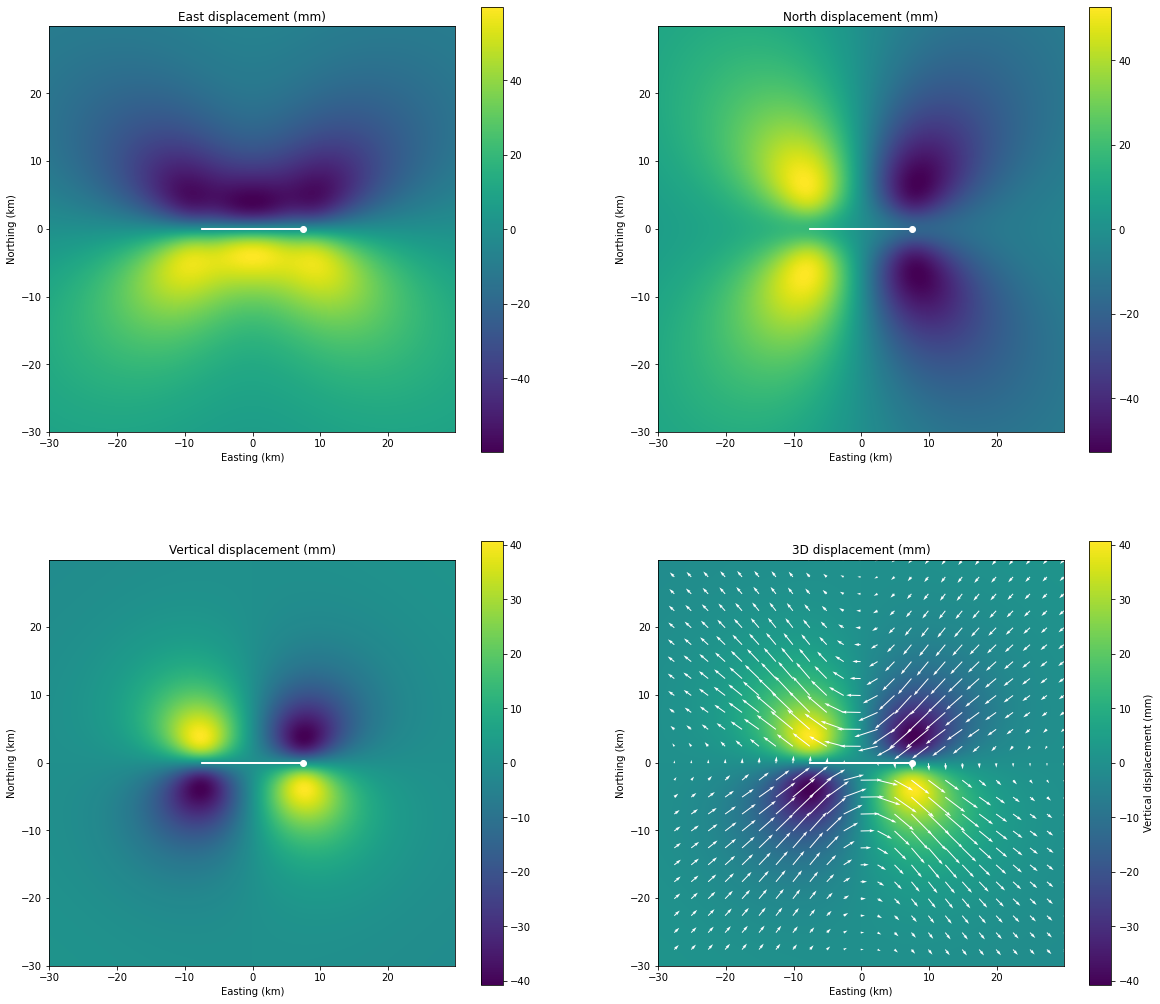

In [25]:
# Generate and plot a simple strike-slip model

importlib.reload(lib)

# Define the fault model
xcen = 0          # centre of fault trace in x (m)
ycen = 0          # centre of fault trace in y (m)
strike = 90        # strike in degrees
dip =    90         # dip in degrees
rake =   0        # rake in degrees
slip =     1        # magnitude of slip vector in metres
top_depth = 2000       # depth (measured vertically) to top of fault in metres
bottom_depth = 10000    # depth (measured vertically) to bottom of fault in metres
length =  15000        # fault length in metres

model = [xcen, ycen, strike, dip, rake, slip, length, top_depth, bottom_depth]

# Calcualte displacements
disp = lib.disloc3d3(model, coords, ep_lambda, ep_mu)

# Plot the three components of displacement
lib.plot_enu(disp, model, x, y)

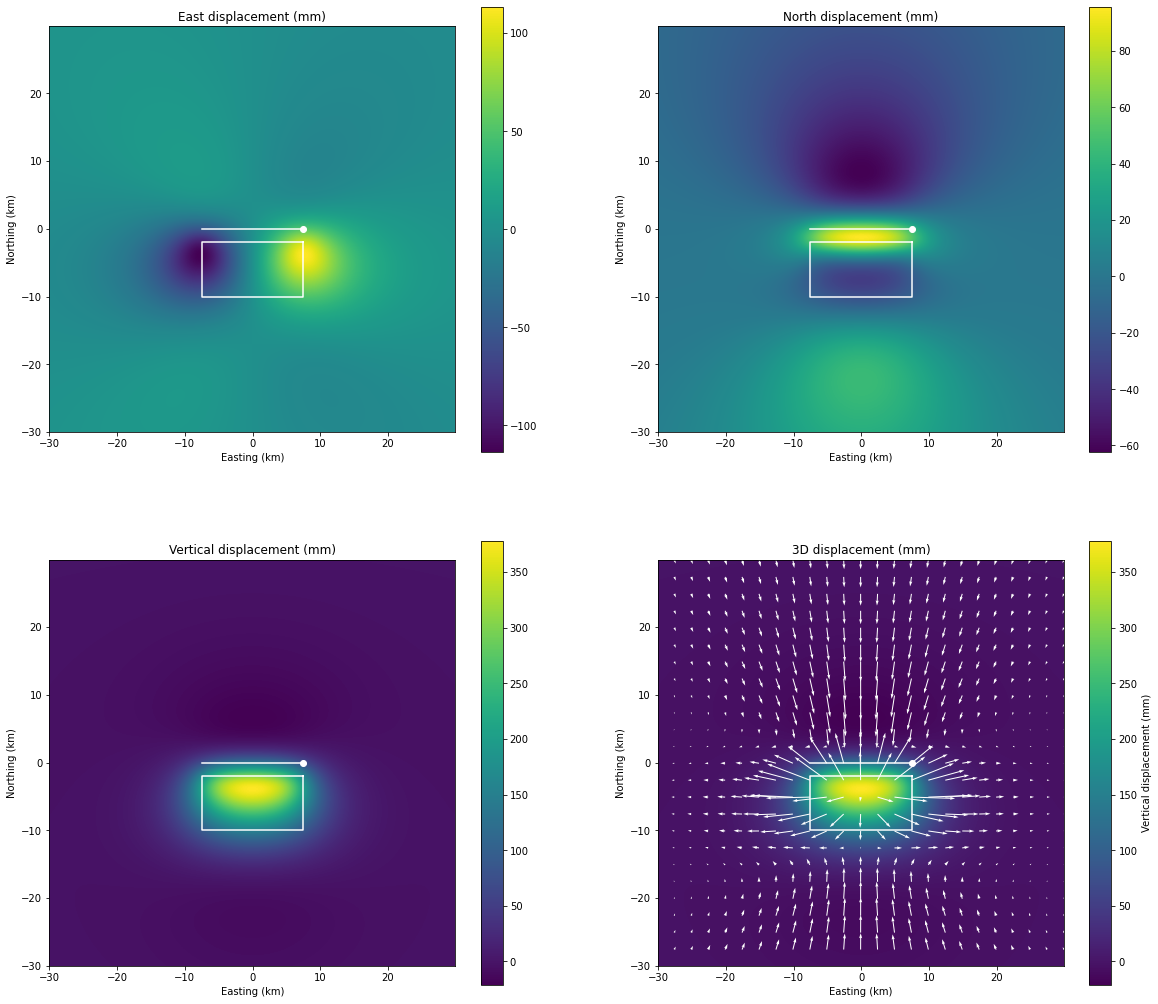

In [26]:
# Same again but for a thrust fault

importlib.reload(lib)

# Define the fault model
xcen = 0          # centre of fault trace in x (m)
ycen = 0          # centre of fault trace in y (m)
strike = 90        # strike in degrees
dip =    45         # dip in degrees
rake =   90        # rake in degrees
slip =     1        # magnitude of slip vector in metres
top_depth = 2000       # depth (measured vertically) to top of fault in metres
bottom_depth = 10000    # depth (measured vertically) to bottom of fault in metres
length =  15000        # fault length in metres

model = [xcen, ycen, strike, dip, rake, slip, length, top_depth, bottom_depth]

# Calcualte displacements
disp = lib.disloc3d3(model, coords, ep_lambda, ep_mu)

# Plot the three components of displacement
lib.plot_enu(disp, model, x, y)

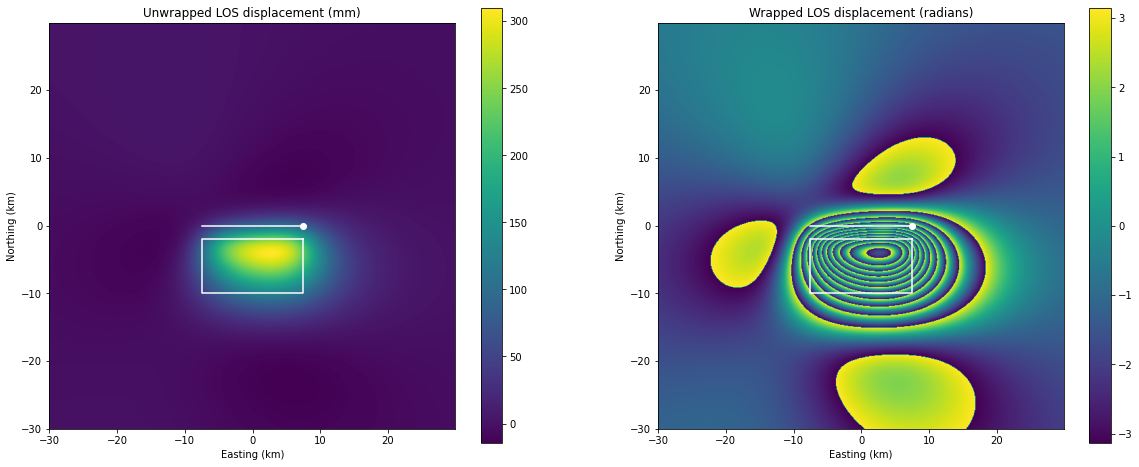

In [27]:
# Plot the same earthquake model projected into the satellite line-of-sight (LOS).

importlib.reload(lib)

# Assuming a fixed azimuth and incidence angle
incidence_angle = 38
azimuth_angle = -10

# Convert to unit vector components
e2los = np.cos(np.deg2rad(azimuth_angle)) * np.sin(np.deg2rad(incidence_angle))
n2los = np.sin(np.deg2rad(azimuth_angle)) * np.sin(np.deg2rad(incidence_angle))
u2los = np.cos(np.deg2rad(incidence_angle))

# Plot unwrapped and wrapped LOS displacements
lib.plot_los(disp, model, x, y, e2los, n2los, u2los)

## 4. Real-world example: The 2017 Sarpol-e Zahab Earthquake

Next, we're going to look at a real interferogram from the 12th November 2017 Sarpol-e Zahab Earthquake in Iran.
The provided interferogram spans 20171107--20171119, and is part of LiCS frame "006D_05509_131313".
I have converted the coordinates from latitude-longitude to UTM, since our modelling assumes distances in metres, and centred the coords within the interferogram to make it easier to work with.

This interferogram highlights a common problem for InSAR studies of coseismic deformation - the signal is cropped by the edge of the track. Normally, we would use multiple interferograms from different tracks and different look directions, but here we'll just see what we can model with a single track.

The interferogram is provided as a float32 binary file with an associated text parameter file that defines its dimentions. The wrapped interferogram has been left in radians, while the unwrapped has been converted to metres.

Text(0.5, 1.0, 'Wrapped LOS displacement (radians)')

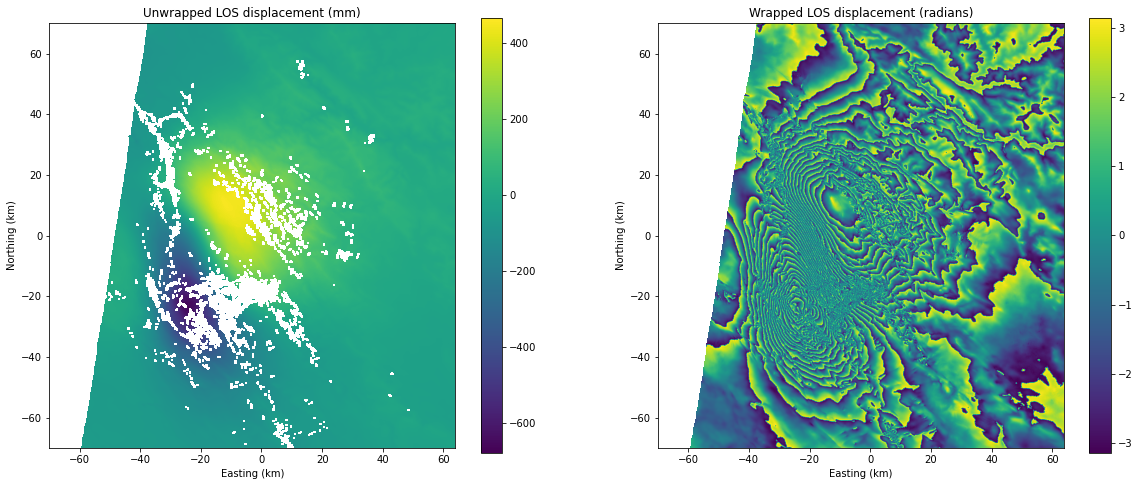

In [28]:
# Begin by loading and plotting the interferogram.

importlib.reload(lib)

# Set the file paths
sarpol_unw_file = 'data/sarpol.unw'
sarpol_diff_file = 'data/sarpol.diff'
sarpol_param_file = 'data/sarpol.par'

# Read height and width in pixels from parameter file
ifg_length = int(lib.get_par(sarpol_param_file,'length'))
ifg_width = int(lib.get_par(sarpol_param_file,'width'))

# Read coordinates of bottom corner
corner_x = float(lib.get_par(sarpol_param_file,'corner_x'))
corner_y = float(lib.get_par(sarpol_param_file,'corner_y'))

# Read spacing of coordinates
x_spacing = float(lib.get_par(sarpol_param_file,'x_spacing'))
y_spacing = float(lib.get_par(sarpol_param_file,'y_spacing'))

# Generate coordinate grids
x = corner_x + x_spacing*np.arange(1,ifg_width+1) - x_spacing/2
y = corner_y + y_spacing*np.arange(1,ifg_length+1) - y_spacing/2

# Load the interferogram
sarpol_unw = np.fromfile(sarpol_unw_file, dtype='float32').reshape((ifg_length, ifg_width))
sarpol_diff = np.fromfile(sarpol_diff_file, dtype='float32').reshape((ifg_length, ifg_width))

# Setup plot
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
extent = (x[0]/1000, x[-1]/1000, y[0]/1000, y[-1]/1000)

# Plot unwrapped
im_u = ax[0].imshow(sarpol_unw*1000, extent=extent, origin='lower')
fig.colorbar(im_u, ax=ax[0])
ax[0].set_xlabel('Easting (km)')
ax[0].set_ylabel('Northing (km)')
ax[0].set_title('Unwrapped LOS displacement (mm)')

# Plot wrapped
im_w = ax[1].imshow(sarpol_diff, extent=extent, origin='lower')
fig.colorbar(im_w, ax=ax[1])
ax[1].set_xlabel('Easting (km)')
ax[1].set_ylabel('Northing (km)')
ax[1].set_title('Wrapped LOS displacement (radians)')

/nfs/a285/homes/eearw/demonstrating/coseismic_practical/coseis_lib.py:230: RuntimeWarning: invalid value encountered in remainder
  resid = los_grid - data_unw
/nfs/a285/homes/eearw/demonstrating/coseismic_practical/coseis_lib.py:234: RuntimeWarning: invalid value encountered in remainder
  end1x, end2x, end1y, end2y, c1x, c2x, c3x, c4x, c1y, c2y, c3y, c4y = fault_for_plotting(model)


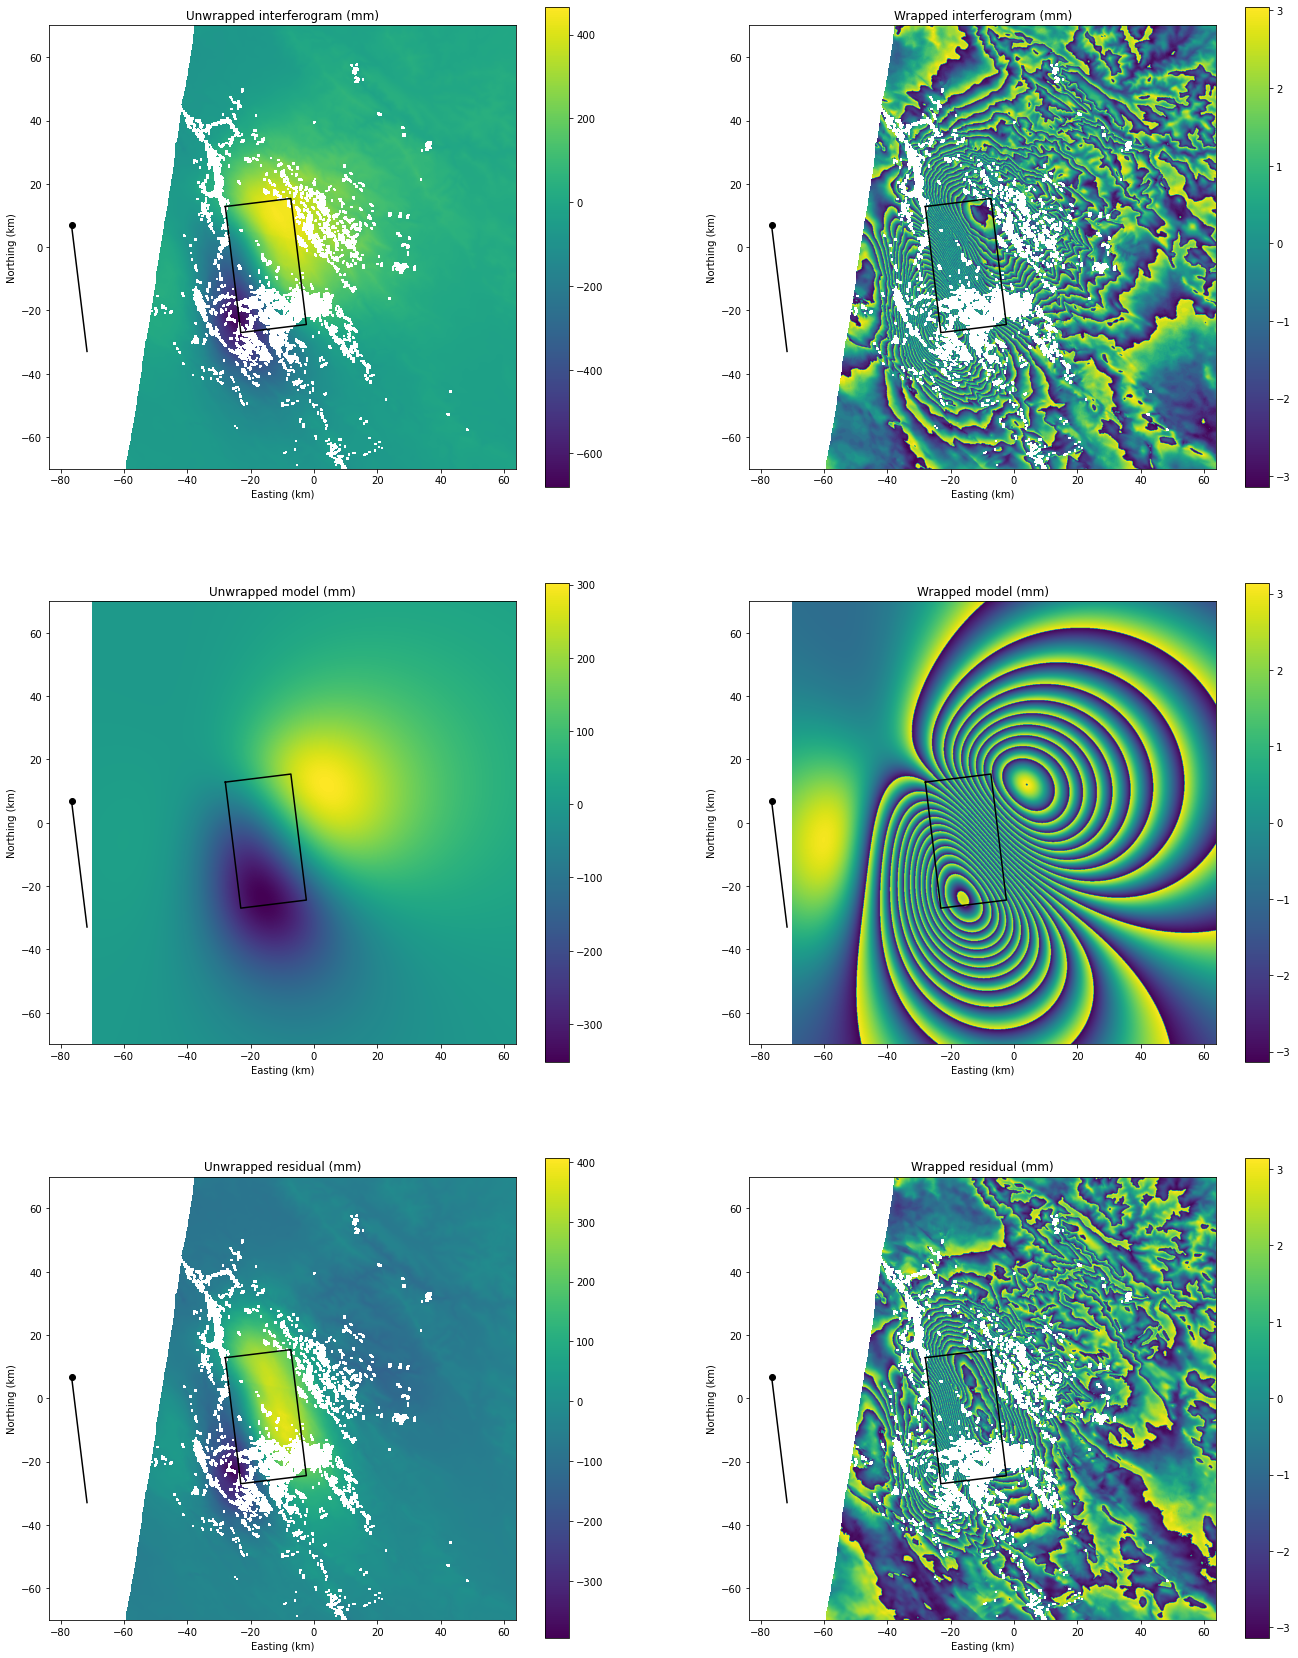

In [29]:
importlib.reload(lib)

# We'll use the same vectors of coordinates as the interferogram
xx, yy = np.meshgrid(x, y)

# convert to pair of coordinates for our dislocation model
xx_vec = np.reshape(xx, -1)
yy_vec = np.reshape(yy, -1)
coords = np.vstack((xx_vec, yy_vec))

# elastic params
ep_lambda = 3.2e10
ep_mu = 3.2e10

# Assuming a fixed azimuth and incidence angle
incidence_angle = 45
azimuth_angle = -11

# Convert to unit vector components
e2los = np.cos(np.deg2rad(azimuth_angle)) * np.sin(np.deg2rad(incidence_angle))
n2los = np.sin(np.deg2rad(azimuth_angle)) * np.sin(np.deg2rad(incidence_angle))
u2los = np.cos(np.deg2rad(incidence_angle))

# Define the fault model
xcen = -74089         # centre of fault trace in x (m)
ycen = -13025          # centre of fault trace in y (m)
strike = 353        # strike in degrees
dip =    14         # dip in degrees
rake =   137        # rake in degrees
slip =     -4        # magnitude of slip vector in metres
top_depth = 12.2 * 1000       # depth (measured vertically) to top of fault in metres
bottom_depth = 17.4 * 1000   # depth (measured vertically) to bottom of fault in metres
length =  40.1 * 1000        # fault length in metres

model = [xcen, ycen, strike, dip, rake, slip, length, top_depth, bottom_depth]

# Calcualte displacements
disp = lib.disloc3d3(model, coords, ep_lambda, ep_mu)

# Plot comparison
lib.plot_data_model(x, y, disp, model, sarpol_unw, e2los, n2los, u2los)